In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the data
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [11]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [12]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [13]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\prateeksood\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [19]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


### 1.1 Defining the Architecture of LSTM (without hyper-parameter tuning)

In [24]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(units = n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### 1.2 Training the model

In [23]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 92s 13ms/step - loss: 1.3018 - acc: 0.4395 - val_loss: 1.1254 - val_acc: 0.4662
Epoch 2/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.9666 - acc: 0.5880 - val_loss: 0.9491 - val_acc: 0.5714
Epoch 3/30
7352/7352 [==============================] - 97s 13ms/step - loss: 0.7812 - acc: 0.6408 - val_loss: 0.8286 - val_acc: 0.5850
Epoch 4/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.6941 - acc: 0.6574 - val_loss: 0.7297 - val_acc: 0.6128
Epoch 5/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.6336 - acc: 0.6912 - val_loss: 0.7359 - val_acc: 0.6787
Epoch 6/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.5859 - acc: 0.7134 - val_loss: 0.7015 - val_acc: 0.6939
Epoch 7/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.5692 - acc: 0.7477 - val_loss: 0.5995 - val_acc: 0.7387


In [24]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [27]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [28]:
score

[0.3087582236972612, 0.9097387173396675]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can try to further imporve the performace with Hyperparameter tuning

### 2.1 Hyper-Parameter Tuning for LSTM Units

In [17]:
def create_model(units=8):
    model = Sequential()
    model.add(LSTM(units, input_shape=(timesteps, input_dim)))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])  
    return model

In [14]:
# Utility function to report best scores
#reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [15]:
#Reference: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
# "Plot train and validation loss"
def PlotLoss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [35]:
from time import time
units = [8,16,32,48,64]

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)
param_grid = dict(units=units)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 3,  verbose = 1)
start = time()
grid_result = grid.fit(X_train, Y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid.cv_results_['params'])))
report(grid.cv_results_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 150.9min finished


GridSearchCV took 10129.99 seconds for 5 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.923 (std: 0.020)
Parameters: {'units': 64}

Model with rank: 2
Mean validation score: 0.908 (std: 0.016)
Parameters: {'units': 32}

Model with rank: 3
Mean validation score: 0.886 (std: 0.040)
Parameters: {'units': 48}

Model with rank: 4
Mean validation score: 0.760 (std: 0.088)
Parameters: {'units': 16}

Model with rank: 5
Mean validation score: 0.661 (std: 0.051)
Parameters: {'units': 8}



In [21]:
#now test model with best LSTM units no
epochs = 30
batch_size = 16
n_hidden = 64

In [20]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(units = n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### 2.2 Training the model with tuned no of LSTM units

In [23]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 34s 5ms/step - loss: 1.3220 - acc: 0.4294 - val_loss: 1.1582 - val_acc: 0.4673
Epoch 2/30
7352/7352 [==============================] - 33s 4ms/step - loss: 0.9982 - acc: 0.5690 - val_loss: 0.9342 - val_acc: 0.5898
Epoch 3/30
7352/7352 [==============================] - 34s 5ms/step - loss: 0.8056 - acc: 0.6434 - val_loss: 0.7617 - val_acc: 0.6101
Epoch 4/30
7352/7352 [==============================] - 34s 5ms/step - loss: 0.7199 - acc: 0.6523 - val_loss: 0.7468 - val_acc: 0.6206
Epoch 5/30
7352/7352 [==============================] - 33s 5ms/step - loss: 0.6646 - acc: 0.6691 - val_loss: 0.7212 - val_acc: 0.6301
Epoch 6/30
7352/7352 [==============================] - 34s 5ms/step - loss: 0.6324 - acc: 0.6806 - val_loss: 0.7913 - val_acc: 0.6437
Epoch 7/30
7352/7352 [==============================] - 34s 5ms/step - loss: 0.6815 - acc: 0.6737 - val_loss: 0.7873 - val_acc: 0.5935
Epoch 8

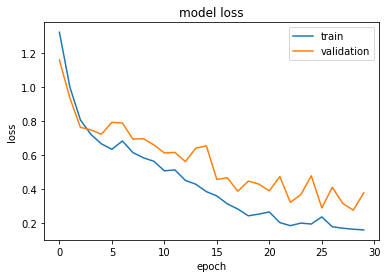

In [24]:
#plot train and validation loss for each epoch
PlotLoss(history)

In [25]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      421        68        0                   0   
STANDING                 0      137       395        0                   0   
WALKING                  0        0         0      420                  31   
WALKING_DOWNSTAIRS       0        0         0        0                 408   
WALKING_UPSTAIRS         0        1         0        0                   9   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                           45  
WALKING_DOWNSTAIRS                12  
WALKING_UPSTAIRS                 461  


In [26]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 1s 496us/step


[0.3764044049231972, 0.8965049202578894]

### 3.1 Hyper-Parameter Tuning for Dropout rate

In [16]:
def create_model_dropout(dropout_rate=0.0):
    model = Sequential()
    model.add(LSTM(32, input_shape=(timesteps, input_dim)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])  
    return model

In [31]:
from time import time
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_model_dropout, epochs=epochs, batch_size=batch_size, verbose=0)
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 3,  verbose = 0)
start = time()
grid_result = grid.fit(X_train, Y_train)
#print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      #% (time() - start, len(grid.cv_results_['params'])))
report(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.905 (std: 0.021)
Parameters: {'dropout_rate': 0.0}

Model with rank: 2
Mean validation score: 0.831 (std: 0.028)
Parameters: {'dropout_rate': 0.4}

Model with rank: 3
Mean validation score: 0.823 (std: 0.108)
Parameters: {'dropout_rate': 0.3}

Model with rank: 4
Mean validation score: 0.814 (std: 0.135)
Parameters: {'dropout_rate': 0.1}

Model with rank: 5
Mean validation score: 0.808 (std: 0.129)
Parameters: {'dropout_rate': 0.2}



In [28]:
#now test model with best dropout rate
epochs = 30
batch_size = 16
n_hidden = 32
#dropout_rate = grid.best_params_.get('dropout_rate') #best dropout rate=0 here which means no dropout
dropout_rate = 0 #best dropout rate=0 here which means no dropout

In [29]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(units = n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(dropout_rate))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 3.2 Training the model with tuned drop-out rate

In [31]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 40s 5ms/step - loss: 1.3799 - acc: 0.3991 - val_loss: 1.3432 - val_acc: 0.4062
Epoch 2/30
7352/7352 [==============================] - 38s 5ms/step - loss: 1.2257 - acc: 0.4436 - val_loss: 1.1758 - val_acc: 0.4788
Epoch 3/30
7352/7352 [==============================] - 37s 5ms/step - loss: 1.0622 - acc: 0.5250 - val_loss: 1.1087 - val_acc: 0.4690
Epoch 4/30
7352/7352 [==============================] - 33s 5ms/step - loss: 0.9091 - acc: 0.5917 - val_loss: 0.8626 - val_acc: 0.5887
Epoch 5/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.6878 - acc: 0.6753 - val_loss: 0.7019 - val_acc: 0.6468
Epoch 6/30
7352/7352 [==============================] - 36s 5ms/step - loss: 0.6003 - acc: 0.7515 - val_loss: 0.6141 - val_acc: 0.7475
Epoch 7/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.5375 - acc: 0.8239 - val_loss: 0.6639 - val_acc: 0.7930
Epoch 8

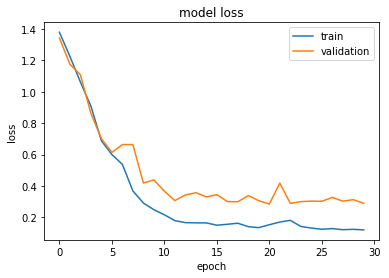

In [32]:
#plot train and validation loss for each epoch
PlotLoss(history)

In [33]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 528        0         8        0                   0   
SITTING                  1      397        92        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  1        3         6      458                  25   
WALKING_DOWNSTAIRS       0        0         0        3                 408   
WALKING_UPSTAIRS         0        0         0       10                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            1  
STANDING                           0  
WALKING                            3  
WALKING_DOWNSTAIRS                 9  
WALKING_UPSTAIRS                 443  


In [34]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 1s 435us/step


[0.2894006351718169, 0.9090600610790635]

### 3.3 Let's test model with second best dropout rate = 0.4 since the we tested with dropout=0 which means no dropout

In [17]:
epochs = 30
batch_size = 16
n_hidden = 32
dropout_rate = 0.4

In [20]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(units = n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(dropout_rate))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 3.4 Training the model with tuned hyper-parameters

In [22]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 64s 9ms/step - loss: 1.4165 - acc: 0.4112 - val_loss: 1.2770 - val_acc: 0.4381
Epoch 2/30
7352/7352 [==============================] - 60s 8ms/step - loss: 1.1939 - acc: 0.4679 - val_loss: 1.2056 - val_acc: 0.4510
Epoch 3/30
7352/7352 [==============================] - 59s 8ms/step - loss: 1.1167 - acc: 0.5297 - val_loss: 1.0848 - val_acc: 0.5504
Epoch 4/30
7352/7352 [==============================] - 59s 8ms/step - loss: 0.9044 - acc: 0.5809 - val_loss: 0.8192 - val_acc: 0.5819
Epoch 5/30
7352/7352 [==============================] - 75s 10ms/step - loss: 0.8711 - acc: 0.5786 - val_loss: 0.8907 - val_acc: 0.5572
Epoch 6/30
7352/7352 [==============================] - 76s 10ms/step - loss: 0.8376 - acc: 0.5722 - val_loss: 0.8900 - val_acc: 0.6074
Epoch 7/30
7352/7352 [==============================] - 62s 8ms/step - loss: 0.7950 - acc: 0.6046 - val_loss: 0.8063 - val_acc: 0.6016
Epoch

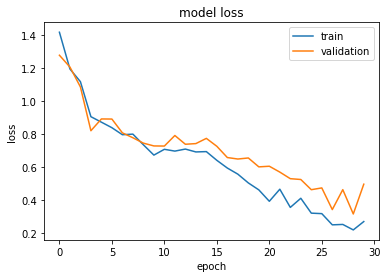

In [23]:
#plot train and validation loss for each epoch
PlotLoss(history)

In [24]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      372        95        1                   0   
STANDING                 0      102       414        0                   0   
WALKING                  0        0         0      406                  58   
WALKING_DOWNSTAIRS       0        2         1       26                 378   
WALKING_UPSTAIRS         0        1         0       22                  48   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                           23  
STANDING                          16  
WALKING                           32  
WALKING_DOWNSTAIRS                13  
WALKING_UPSTAIRS                 400  


In [25]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 2s 814us/step


[0.49494662675608364, 0.841533763148965]

## 4.1 Using 2 layer LSTM

In [27]:
epochs = 30
batch_size = 16
n_hidden = 32

In [28]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(units = n_hidden, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding dropout layer
model.add(Dropout(0.7)) #using high dropout for multi-layer LSTM
model.add(LSTM(units = n_hidden, return_sequences=False))
# Adding dropout layer
model.add(Dropout(0.7))#using high dropout for multi-layer LSTM
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### 4.2 Training the model with tuned hyper-parameters

In [30]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 160s 22ms/step - loss: 1.2779 - acc: 0.4819 - val_loss: 0.9117 - val_acc: 0.6732
Epoch 2/30
7352/7352 [==============================] - 138s 19ms/step - loss: 0.8940 - acc: 0.6162 - val_loss: 1.0816 - val_acc: 0.5721
Epoch 3/30
7352/7352 [==============================] - 141s 19ms/step - loss: 0.7768 - acc: 0.6655 - val_loss: 0.7062 - val_acc: 0.6491
Epoch 4/30
7352/7352 [==============================] - 146s 20ms/step - loss: 0.7394 - acc: 0.6838 - val_loss: 0.7680 - val_acc: 0.6946
Epoch 5/30
7352/7352 [==============================] - 141s 19ms/step - loss: 0.6738 - acc: 0.7218 - val_loss: 0.7396 - val_acc: 0.7285
Epoch 6/30
7352/7352 [==============================] - 144s 20ms/step - loss: 0.6109 - acc: 0.7571 - val_loss: 0.6059 - val_acc: 0.7397
Epoch 7/30
7352/7352 [==============================] - 138s 19ms/step - loss: 0.5164 - acc: 0.7890 - val_loss: 0.6309 - val_acc: 

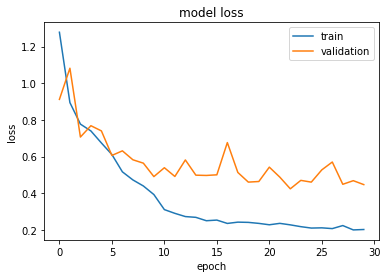

In [31]:
#plot train and validation loss for each epoch
PlotLoss(history)

In [32]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        26        0                   0   
SITTING                  0      416        71        2                   0   
STANDING                 0       94       437        1                   0   
WALKING                  0        0         8      461                   0   
WALKING_DOWNSTAIRS       0        0         0       14                 404   
WALKING_UPSTAIRS         0        0         0       27                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            2  
STANDING                           0  
WALKING                           27  
WALKING_DOWNSTAIRS                 2  
WALKING_UPSTAIRS                 444  


In [33]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 6s 2ms/step


[0.44670626869502744, 0.9066847641669494]

### 4.3 Check 2-Layer LSTM with dropout 0.5

In [35]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(units = n_hidden, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(units = n_hidden, return_sequences=False))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### 4.4 Training the model with tuned hyper-parameters

In [37]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 144s 20ms/step - loss: 1.1797 - acc: 0.4864 - val_loss: 0.8961 - val_acc: 0.6478
Epoch 2/30
7352/7352 [==============================] - 133s 18ms/step - loss: 0.8111 - acc: 0.6315 - val_loss: 0.7868 - val_acc: 0.6888
Epoch 3/30
7352/7352 [==============================] - 142s 19ms/step - loss: 0.6812 - acc: 0.6961 - val_loss: 0.6771 - val_acc: 0.7224
Epoch 4/30
7352/7352 [==============================] - 131s 18ms/step - loss: 0.5615 - acc: 0.7612 - val_loss: 0.6316 - val_acc: 0.7245
Epoch 5/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.4945 - acc: 0.7802 - val_loss: 0.5294 - val_acc: 0.7574
Epoch 6/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.4047 - acc: 0.8132 - val_loss: 0.7037 - val_acc: 0.7404
Epoch 7/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.3696 - acc: 0.8517 - val_loss: 0.5196 - val_acc: 0.8

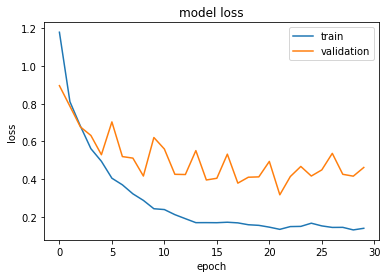

In [38]:
#plot train and validation loss for each epoch
PlotLoss(history)

In [39]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 511        0         0        0                   0   
SITTING                  6      419        48        0                   0   
STANDING                 0      119       385        1                   0   
WALKING                  0        0         0      446                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 408   
WALKING_UPSTAIRS         0        0         0        4                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            26  
SITTING                           18  
STANDING                          27  
WALKING                           48  
WALKING_DOWNSTAIRS                12  
WALKING_UPSTAIRS                 467  


In [40]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 3s 1ms/step


[0.4617388741920498, 0.8944689514760774]

# Summary

In [3]:
x = PrettyTable()
#print details of single layer LSTM
x.field_names = ["Epochs","Batch Size","Hidden Units","Dropout", "Loss", "Accuracy"]
x.add_row([30,16,32,0.5,0.308, 0.909])
x.add_row([30,16,64,0.5,0.376, 0.896])
x.add_row([30,16,32,0,0.289, 0.909])
x.add_row([30,16,32,0.4,0.494, 0.841])
print("Results of 1 layer LSTM")
print(x)

Results of 1 layer LSTM
+--------+------------+--------------+---------+-------+----------+
| Epochs | Batch Size | Hidden Units | Dropout |  Loss | Accuracy |
+--------+------------+--------------+---------+-------+----------+
|   30   |     16     |      32      |   0.5   | 0.308 |  0.909   |
|   30   |     16     |      64      |   0.5   | 0.376 |  0.896   |
|   30   |     16     |      32      |    0    | 0.289 |  0.909   |
|   30   |     16     |      32      |   0.4   | 0.494 |  0.841   |
+--------+------------+--------------+---------+-------+----------+


#### <u>Observation</u>: While tuning the drop-out rate to 0, we were able to decrease the loss

In [41]:
x = PrettyTable()
#print details of 2 layer LSTM
x.field_names = ["Epochs","Layers","Batch Size","Hidden Units","Dropout", "Loss", "Accuracy"]
x.add_row([30,2,16,32,0.7,0.446, 0.906])
x.add_row([30,2,16,32,0.5,0.461, 0.894])
print("Results of 2 layer LSTM")
print(x)

Results of 2 layer LSTM
+--------+--------+------------+--------------+---------+-------+----------+
| Epochs | Layers | Batch Size | Hidden Units | Dropout |  Loss | Accuracy |
+--------+--------+------------+--------------+---------+-------+----------+
|   30   |   2    |     16     |      32      |   0.7   | 0.446 |  0.906   |
|   30   |   2    |     16     |      32      |   0.5   | 0.461 |  0.894   |
+--------+--------+------------+--------------+---------+-------+----------+
